# Einsendeaufgabe 3: Numba (100 Punkte)

In diesem Abschnitt möchten wir unsere Applikationen mit Numba beschleunigen.

## Mandelbrot-Set (10 Punkte)

Wir beginnen mit einem klassischen Beispiel für Parallelisierung: dem Mandelbrot-Set.

Die Mandelbrot-Menge wird durch die Gleichung $z_{n+1} = z_n^2 + c$ beschrieben. In dieser Gleichung sind $c$ und $z$ komplexe Zahlen, und $n$ ist Null oder eine positive ganze Zahl. Ausgehend von $z_0=0$, gehört $c$ zur Mandelbrot-Menge, wenn der Absolutwert von $z_n$ niemals größer als eine bestimmte Zahl wird (diese Zahl ist abhängig von $c$), egal wie groß $n$ wird.

Das bedeutet, eine komplexe Zahl $c$ ist ein Element der Mandelbrotmenge, wenn die Beträge der mit diesem $c$ berechneten $z_{n}$ nicht unbegrenzt wachsen, unabhängig davon, wie groß $n$ wird. Es lässt sich leicht zeigen, dass der Betrag von $z_{n}$ unbegrenzt wächst, sobald ein $z_{n}$ mit $|z_{n}|>2$ auftritt.

Bei der Berechnung des Mandelbrot-Sets legt man oft eine obere Grenze für die maximalen Iterationen fest, um zu testen, ob diese überschritten wird.

Ein einfacher Algorithmus zur Bestimmung, ob ein Wert zum Mandelbrot-Set gehört, sieht folgendermaßen aus:

In [ ]:
import numba
import numpy as np


def escape_time(p, maxiter):
    """Perform the Mandelbrot iteration until it's clear that p diverges
    or the maximum number of iterations has been reached.

    Parameters
    ----------
    p: complex
        point in the complex plane
    maxiter: int
        maximum number of iterations to perform before p is considered in
        the Mandelbrot set.
    """
    z = 0j
    for i in range(maxiter):
        z = z**2 + p
        if abs(z) > 2:
            return i
    return maxiter


a = np.array([0.2 + 0.2j])
escape_time(a, 400)

Die Zahl $0.2+0.2j$ liegt also in der Mandelbrot Menge, da wir nach 400 Iterationen noch nicht die Abbruchbedingung erfüllen.  Allerdings ist es mühsam, jede Zahl einzeln zu testen. Wir erstellen also ein 2-D Feld mit vielen Komplexen Zahlen $|z|<2$: 

In [ ]:
real_param = (-1.5, 1.1, 1500)
imag_param = (-1.5j, 1.1j, 1500)
XX, YY = np.meshgrid(np.linspace(*real_param), np.linspace(*imag_param))
P = XX + YY

<!-- BEGIN QUESTION -->

**Aufgabe:**  
- Vektorisieren Sie die Funktion mit `np.vectorize`
- Vektorisieren Sie die Funktion mit `numba.vectorize`
- Testen Sie, ob der Parallel-Parameter funktioniert und ob er Performance-Vorteile bringt
- Vergleichen Sie die Laufzeit der drei Versionen und stellen Sie den Vergleich graphisch dar

_Points:_ 7

In [ ]:
mandelbrot_set_np_vectorized = ...
mandelbrot_set_numba_vectorized = ...
mandelbrot_set_numba_vectorized_par = ...
...

In [ ]:
maxiter = 200
...

<!-- END QUESTION -->

Mit *plt.imshow(M)* können Sie sich die Mandelbrotmenge $M$ ansehen: 

In [ ]:
M = mandelbrot_set_numba_vectorized_par(P, maxiter)
plt.imshow(M)

<!-- BEGIN QUESTION -->

**Aufgabe:** Vergleichen Sie nun die drei Versionen mit Scalene. Verwenden sie eine Sampling-Rate von $0.0001$

_Points:_ 3

In [1]:
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
,supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
,profiling, use the command line version. To profile in line mode, use
,`%scrun [options] statement`. To profile in cell mode, use `%%scalene
,[options]` followed by your code.


In [ ]:
%%scalene --cpu-sampling-rate 0.0001
...

<!-- END QUESTION -->

## Springende Bälle, Teil 2 (60 Punkte)
Wir wollen die Simulation mit mehreren Bällen verbessern und optimieren. 

Jetzt werden zusätzlich Kollisionen zwischen den Bällen beachtet.
Dafür wollen wir zunächst berechnen, ob die Bälle in einem Zeitschritt kollidieren. Eine genaue Berechnung ist hier sehr schwer, daher können wir dies nur näherungsweise machen. Wir müssen dazu auch folgende Annahmen machen:

1. Die Bälle haben einen Radius von $r$, alle Bälle sind gleich groß 
2. Der Zeitschritt $\Delta t$ und die Geschwindigkeit $\$v$ der Bälle sind so gewählt, dass ein Ball maximal viermal seinen Radius in einem Zeitschritt zurücklegt, also $v*\Delta t <= 4*r$


Wir berechnen nun in jeden Zeitschritt zunächst 3 zusätzliche Zwischenzeitschritte:

$ c_0 = c_0$

$c_1 = c_0+0.25\Delta t *v$

$c_3 = c_0+0.5\Delta t *v$

$c_4 = c_0+0.75\Delta t * v$

(Der nächste Schritt wäre $\Delta t$, dieser wird aber in der nächsten Iteration beachtet.)


Wir betrachten nun jeweils für 2 Bälle, ob sie sich in einem der Zwischenzeitschritte näher als zweimal dem Radius $r$ kommen. Wenn sie das tun, gibt es eine Kollision.

<!-- BEGIN QUESTION -->

**Aufgabe:** Schreiben Sie eine Funktion, die dies für zwei Bälle testet und zunächst `True` oder `False` zurück gibt. Für die Berechnung des Abstands können sie die Funktion `np.linalg.norm` verwenden.

_Points:_ 10

In [5]:
import numpy as np

def will_collide(c1, c2, v1, v2, r1, r2, dt):
    """
    Prüft, ob zwei Bälle sich innerhalb eines Zeitschritts dt kollidieren werden

    Parameter:
    - c1, c2:   Positionen von Ball 1 und 2 
    - v1, v2:   Geschwindigkeiten von Ball 1 und 2
    - r1, r2:   Radien von Ball 1 und 2
    - dt:       Zeitschritt

    Rückgabewerte:
    - collided:                 Status: Ob eine Kollision erkannt wurde      
    - k_frac:                   Fraktion des Zeitschritts, bei dem die Kollision stattfindet
    - c1_before, c2_before:     Positionen von Ball 1 und 2 vor der Kollision
    """

    # Vorinitialisierung
    collided = False
    k_frac = 0
    c1_before = c1
    c2_before = c2
    k_values = [0, 0.25, 0.5, 0.75]  # Zeitanteile innerhalb des Zeitschritts

    for k in k_values:
        # Positionen der Bälle nach k * dt
        c1_pos = c1 + k * dt * v1
        c2_pos = c2 + k * dt * v2

        # Berechnung des Abstands zwischen den Bällen nach jedem k
        distance = np.linalg.norm(c1_pos - c2_pos)

        # Wenn Abstand kleiner als die Summe der Radien beider Bälle ist -> Kollision
        if distance < (r1 + r2):
            # Aktualisierung der Werte
            collided = True
            k_frac = k
            c1_before = c1_pos
            c2_before = c2_pos
            break  # Kollision gefunden -> Abbruch der Schleife

    return collided, k_frac, c1_before, c2_before


<!-- END QUESTION -->

Um die Geschwindigkeiten der Bälle nach einer Kollision zu berechnen, können wir die Erhaltung des Impulses und die Erhaltung der kinetischen Energie heranziehen, unter der Annahme, dass es sich um eine vollkommen elastische Kollision handelt. Bei einer solchen Kollision bleiben sowohl der Gesamtimpuls als auch die gesamte kinetische Energie des Systems erhalten. Die Berechnungen werden allerdings etwas komplexer, wenn wir Richtungen berücksichtigen.

#### Geschwindigkeiten nach der Kollision

Für zwei Bälle mit Massen $m_1$ und $m_2$, den Anfangsgeschwindigkeiten $v_1$ und $v_2$ und den Endgeschwindigkeiten $v_1'$ und $v_2'$ gelten folgende Gleichungen basierend auf dem Impulserhaltungssatz und der Erhaltung der kinetischen Energie:

1. **Impulserhaltung:**
   $m_1 v_1 + m_2 v_2 = m_1 v_1' + m_2 v_2'$

2. **Erhaltung der kinetischen Energie:**
   $\frac{1}{2} m_1 v_1^2 + \frac{1}{2} m_2 v_2^2 = \frac{1}{2} m_1 {v_1'}^2 + \frac{1}{2} m_2 {v_2'}^2$

Diese Gleichungen müssen vektoriell gelöst werden, da die Geschwindigkeiten Richtungen haben.

Die Lösungen für die Geschwindigkeiten nach der Kollision in zwei Dimensionen unter der Annahme einer vollkommen elastischen Kollision und unter Ignorierung der Rotation der Bälle sind:

$v_1' = v_1 - \frac{2 m_2}{m_1 + m_2} \frac{(v_1 - v_2) \cdot (c_1 - c_2)}{\|c_1 - c_2\|^2} (c_1 - c_2)$

$v_2' = v_2 + \frac{2 m_1}{m_1 + m_2} \frac{(v_1 - v_2) \cdot (c_1 - c_2)}{\|c_1 - c_2\|^2} (c_1 - c_2)$

Hierbei ist $(v_1 - v_2) \cdot (c_1 - c_2)$ das Skalarprodukt der Vektoren $v_1 - v_2$ und $c_1 - c_2$, und $\|c_1 - c_2\|$ ist der Betrag des Vektors $(c_1 - c_2)$, welcher den Abstand zwischen den Zentren der Bälle darstellt.


<!-- BEGIN QUESTION -->

**Aufgabe:** Schreiben Sie eine Funktion, welche die neuen Geschwindigkeiten der Bälle NACH einer Kollision berechnet.  
Sie übergeben der Funktion die folgenden Daten.
- Koordinaten ($c_1, c_2$)
- Geschwindigkeiten ($v_1, v_2$)
- Massen ($m_1, m_2$)

Für die Berechnung des Betrags können Sie wiederum die Funktion `np.linalg.norm` verwenden.

_Points:_ 10

In [6]:
def collision(c1, c2, v1, v2, m1, m2):
    """
    Berechnet die elastische Kollision zwischen den Bällen 1 und 2
    
    Parameter:
    - c1, c2:   Positionen von Ball 1 und 2 
    - v1, v2:   Geschwindigkeiten von Ball 1 und 2
    - r1, r2:   Radien von Ball 1 und 2
    - m1, m2:   Massen von Ball 1 und 2
    
    Rückgabewerte:
    - v1_new, v2_new:   Neue Geschwindigkeiten von Ball 1 und 2 nach Kollision
    """
    
    # Abstand zwischen den Bällen
    r = c1 - c2
    norm_r = np.linalg.norm(r)  # Betrag des Abstandvektors
    
    # Skalarprodukt der Geschwindigkeitsdifferenz und des Positionsvektors
    v_diff = v1 - v2
    scalar_product = np.dot(v_diff, r)
    
    # Faktor für die Geschwindigkeitsänderung
    factor1 = (2 * m2) / (m1 + m2) * (scalar_product / norm_r**2)
    factor2 = (2 * m1) / (m1 + m2) * (scalar_product / norm_r**2)
    
    # Neue Geschwindigkeiten nach Kollision
    v1_new = (v1 - factor1 * r)
    v2_new = (v2 + factor2 * r)
    
    return v1_new, v2_new


def test_collision(case):
    # Online simulator
    # https://phet.colorado.edu/sims/html/collision-lab/latest/collision-lab_all.html
    if case == "x":
        c1 = np.array([1, 1])
        c2 = np.array([2, 1])
        v1 = np.array([1, 0])
        v2 = np.array([-1, 0])
    if case == "y":
        c1 = np.array([1, 1])
        c2 = np.array([1, 2])
        v1 = np.array([0, 1])
        v2 = np.array([0, -1])
    if case == "diagonal":
        c1 = np.array([1, 1])
        c2 = np.array([2, 2])
        v1 = np.array([1, 1])
        v2 = np.array([0, 0])
    if case == "custom":
        c1 = np.array([1, 1])
        c2 = np.array([2, 3])
        v1 = np.array([1, 1])
        v2 = np.array([0, -1])
    v1_new, v2_new = collision(c1, c2, v1, v2, 1, 1)
    assert np.allclose(np.abs(v2 - v1), np.abs(v2_new - v1_new))
    print(f"{v1=}, {v2=}, {v1_new=}, {v2_new=}")

    # different mass
    v1_new, v2_new = collision(c1, c2, v1, v2, 1, 20)
    assert np.allclose(np.abs(v2 - v1), np.abs(v2_new - v1_new))
    print(f"{v1=}, {v2=}, {v1_new=}, {v2_new=}")


test_collision(case="x")
test_collision(case="y")
test_collision(case="diagonal")
test_collision(case="custom")

v1=array([1, 0]), v2=array([-1,  0]), v1_new=array([-1.,  0.]), v2_new=array([1., 0.])
,v1=array([1, 0]), v2=array([-1,  0]), v1_new=array([-2.80952381,  0.        ]), v2_new=array([-0.80952381,  0.        ])
,v1=array([0, 1]), v2=array([ 0, -1]), v1_new=array([ 0., -1.]), v2_new=array([0., 1.])
,v1=array([0, 1]), v2=array([ 0, -1]), v1_new=array([ 0.        , -2.80952381]), v2_new=array([ 0.        , -0.80952381])
,v1=array([1, 1]), v2=array([0, 0]), v1_new=array([2.22044605e-16, 2.22044605e-16]), v2_new=array([1., 1.])
,v1=array([1, 1]), v2=array([0, 0]), v1_new=array([-0.9047619, -0.9047619]), v2_new=array([0.0952381, 0.0952381])
,v1=array([1, 1]), v2=array([ 0, -1]), v1_new=array([ 2.22044605e-16, -1.00000000e+00]), v2_new=array([1., 1.])
,v1=array([1, 1]), v2=array([ 0, -1]), v1_new=array([-0.9047619 , -2.80952381]), v2_new=array([ 0.0952381 , -0.80952381])


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Nun wollen wir eine Funktion implementieren, die alle möglichen Kollisionen in einem Zeitschritt erfasst und die neuen Geschwindigkeiten der Bälle berechnet – und zwar möglichst effizient. 

Dafür sollten Sie die folgenden Dinge beachten:
1. Es macht nicht für alle Ballpaare sinnvoll alle vier Zwischenzeitschritte zu berechnen. Testen Sie daher zunächst, ob sich zwei Bälle bereits näher als $ 8 \cdot r $ sind.
2. Sie können annehmen, dass sich der Ball bis zum Zwischenschritt, in dem die Kollision berechnet wird, mit der alten Geschwindigkeit bewegt, danach mit der neuen. Implementieren Sie dies entsprechend. Achten Sie auch darauf, dass ein Ball, für den eine Kollision berechnet wurde, im selben Zeitschritt keine vollständige Bewegung für $ \Delta t $ mehr macht.
3. Es kann leicht passieren, dass zwei Bälle, die in einem Zeitschritt kollidieren, es nicht schaffen, sich während des Zeitschritts weit genug aufeinander zu bewegen, sodass sie im folgenden Zeitschritt wieder miteinander kollidieren. Das kann dann dazu führen, dass die Bälle sich umkreisen. Um das zu verhindern, verwenden wir eine Maske (`mask`), die dafür sorgt, dass zwei Bälle nicht in zwei (oder mehr) aufeinanderfolgenden Zeitschritten miteinander kollidieren können.

Anmerkung: Die Situation, dass mehrere Bälle gleichzeitig, in einem Zeitschritt kollidieren, kann hier vereinfacht ignoriert werden.

_Points:_ 10

In [7]:
def get_all_collisions(c, v, m, r, dt, mask, cooldown_frames = 4):
    """
    Prüft und behandelt alle möglichen Kollisionen zwischen Bällen
    
    Parameter:
    - c:                aktuelle Positionen von allen Bällen (Array der Form [N, 2])
    - v:                aktuelle Geschwindigkeiten von allen Bällen (Array der Form [N, 2])
    - m:                aktuelle Massen von allen Bällen (Array der Form [N, 2])
    - r:                aktuelle Radien von allen Bällen (Array der Form [N, 2])
    - dt:               Zeitschritt
    - mask:             Maske, die verhindert, dass Bälle nicht mehreren (=cooldown_frames)  
                        aufeinanderfolgenden Zeitschritten miteinander kollidieren können
    - colldown_frames:  Anzahl der Zeitschritte, bis die Bälle nach einer Kollision
                        wieder für die Berechnung der nächsten Kollision berücksichtigt werden können
    
    Rückgabewerte:
    - c:    Neue Positionen der Bälle nach Kollisionen
    - v:    Neue Geschwindigkeiten der Bälle nach Kollisionen
    - mask: Aktualisierte Maske
    """
    
    N = len(c) # Anzahl der Bälle

    for i in range(N):
        for j in range(i + 1, N):
            
            # Prüfe, ob die Bälle maskiert sind
            if mask[i, j] > 0:
                continue  # Maske anwenden -> Kollision wird nicht überprüft

            # Prüfe, ob die Bälle nah genug sind
            distance = np.linalg.norm(c[i] - c[j])
            min_dist = r[i] + r[j]
            if distance >= 4 * min_dist:
                continue  # Bälle sind noch zu weit voneinander -> Kollision wird nicht überprüft
            
            # Prüfe ob die Kollision schon in diesem Zeitschritt stattfindet
            collided, k_frac, c1_before, c2_before = will_collide(c[i], c[j], v[i], v[j], r[i], r[j], dt)

            if collided:
                # Wenn Kollision, dann neue Geschwindigkeiten
                v1_new, v2_new = collision(c[i], c[j], v[i], v[j], m[i], m[j])
      
                # Neue Position nach der Kollision berechnen 
                c[i] = c1_before + v1_new * (1 - k_frac) * dt # neue Position für Ball 1
                c[j] = c2_before + v2_new * (1 - k_frac) * dt # neue Position für Ball 2
                
                # Aktualisierung von v 
                v[i] = v1_new
                v[j] = v2_new
                
                # Aktualisierung der Maske, wenn Kollisionen aufgetreten sind
                mask[i, j] = cooldown_frames
                mask[j, i] = cooldown_frames                
    
    # Aktualisierung der Maske, wenn keine Kollisionen aufgetreten sind
    mask = np.maximum(mask - 1, 0)
    
    return c, v, mask

In [8]:
# Anfangsbedingungen
g = np.array([0, -9.81], dtype=np.float64)
xmax = 100
ymax = 100
steps = 1000
# dt = xmax * 1e-5
dt = 0.1

# Anzahl Bälle
N = 10

rng = np.random.default_rng(seed=123)

# Flag zur Aktivierung der Visualisierung (Trennung der Simulation und Visualisierung)
visualize = True

# Startpositionen
def init(n=N):
    c = xmax * rng.random((N, 2))
    # Startgeschwindigkeiten, max.
    v = np.array([xmax/10, ymax/10]) * rng.random((N, 2))
    # Masse
    m = rng.uniform(5, 15, size=N)
    r = np.sqrt(m) 
    mask = np.full((N, N), 0, np.int32)
    return c, v, m, r, mask

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Implementieren Sie nun einen vollständigen Zeitschritt mit Kollisionen. 

_Points:_ 10

In [9]:
def timestep_with_collisions(c, v, m, dt, g, r, xmax, ymax, mask):
    """
    Führt einen vollständigen Zeitschritt mit Kollisionen durch
    
    Parameter:
    - c:                aktuelle Positionen von allen Bällen (Array der Form [N, 2])
    - v:                aktuelle Geschwindigkeiten von allen Bällen (Array der Form [N, 2])
    - m:                aktuelle Massen von allen Bällen (Array der Form [N, 2])
    - dt:               Zeitschritt
    - g:                Gravitationsvektor
    - r:                aktuelle Radien von allen Bällen (Array der Form [N, 2])
    - xmax, ymax:       Begrenzung des Simulationsraums
    - mask:             Maske, die verhindert, dass Bälle nicht in mehreren (=cooldown_frames)  
                        aufeinanderfolgenden Zeitschritten miteinander kollidieren können

    
    Rückgabewerte:
    - c:    Neue Positionen der Bälle nach dt
    - v:    Neue Geschwindigkeiten der Bälle nach dt
    - mask: Aktualisierte Maske
    """
    
    # Gravitation anwenden
    v = v + g * dt
    c += v * dt

    # Kollisionen zwischen Bällen berechnen
    c, v, mask = get_all_collisions(c, v, m, r, dt, mask)

    # Wandkollisionen behandeln
    # Kollisionen mit linken/rechten Wänden
    left_wall = c[:, 0] <= 0 
    right_wall = c[:, 0] >= xmax 
    if np.any(left_wall | right_wall):
        dt2_left_wall = abs(c[left_wall, 0]) / abs(v[left_wall, 0]) 
        dt2_right_wall = (abs(c[right_wall,0]) - xmax) / abs(v[right_wall, 0]) 
        v[left_wall | right_wall, 0] *= -1 
        c[left_wall, 0] = dt2_left_wall * v[left_wall, 0] 
        c[right_wall, 0] = xmax - dt2_right_wall * v[right_wall, 0] 
    # Kollisionen mit oberen/unteren Wänden
    bottom = c[:, 1] <= 0
    top = c[:, 1] >= ymax
    if np.any(bottom | top):
        dt2_bottom = abs(c[bottom, 1]) / abs(v[bottom, 1])
        dt2_top = (abs(c[top, 1]) - ymax) / abs(v[top, 1])
        v[bottom | top, 1] *= -1
        c[bottom, 1] = dt2_bottom * v[bottom, 1]
        c[top, 1] = ymax - dt2_top * v[top, 1]

    return c, v, mask

GIF wird erstellt...
,GIF gespeichert als: multi_ball_collisions.gif
,Simulation (mit Visualisierung) war erfolgreich


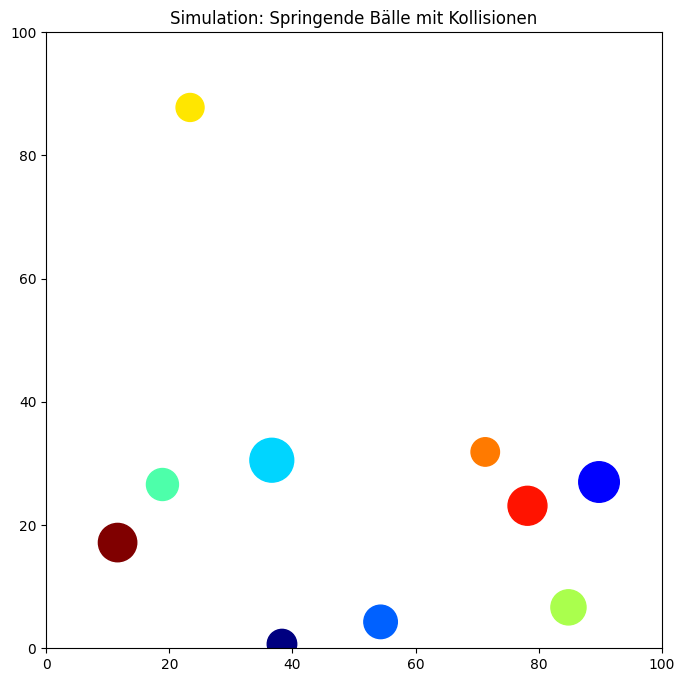

In [11]:
# ------------------------------
# HAUPTFUNKTION
# ------------------------------   

# Initialisierung 
c, v, m, r, mask = init()

if visualize == True:
    # Führe Simulation mit Visualisierung durch und animiere das Ergebnis
    all_positions = [c.copy()]

    for i in range(steps):
        c, v, mask = timestep_with_collisions(c, v, m, dt, g, r, xmax, ymax, mask)
        all_positions.append(c.copy())
    
    animate_positions(all_positions, N, xmax, ymax, r, m)
    print("Simulation (mit Visualisierung) war erfolgreich")
else:
    # Nur reine Simulation ohne Visualisierung
    for i in range(steps):
        timestep_with_collisions(c, v, m, dt, g, r, xmax, ymax, mask)
    print("Simulation (ohne Visualisierung) war erfolgreich")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Animieren Sie die Bewegung der Bälle.

Tipp: Trennen Sie Simulation und Visualisierung und visualisieren Sie z.B. nur jeden 100. Simulationsschritt. 

_Points:_ 5

In [10]:
# Erstellt eine animierte Visualisierung der Positionen
def animate_positions(all_positions, num_balls, xmax, ymax, r, m, filename="multi_ball_collisions.gif"):
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation, PillowWriter
    from matplotlib.patches import Circle
    import numpy as np

    print ("GIF wird erstellt...")
    colors = plt.cm.jet(np.linspace(0, 1, num_balls))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, xmax)
    ax.set_ylim(0, ymax)
    ax.set_aspect('equal')
    ax.set_title("Simulation: Springende Bälle mit Kollisionen")

    # Bälle erstellen
    circles = []
    for i in range(num_balls):
        circle = Circle((0, 0), r[i], color=colors[i])
        ax.add_patch(circle)
        circles.append(circle)

    def init():
        for circle in circles:
            circle.center = (-10, -10) # Anfangs außerhalb des Bildes
        return circles

    def update(frame):
        positions = all_positions[frame]
        for i, circle in enumerate(circles):
            circle.center = positions[i]
        return circles

    ani = FuncAnimation(fig, update, frames=len(all_positions), init_func=init, blit=True, interval=50)
    ani.save(filename, writer=PillowWriter(fps=20))
    print(f"GIF gespeichert als: {filename}")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Analysieren Sie nun die Simulation mit Scalene. Was hat sich gegenüber der alten Version ohne die Kollisionen verändert? 

_Points:_ 5

Wie bereits in der Simulation von springenden Bällen ohne Kollisionen beobachtet, hatte das Speichern und Verwalten der Positionsdaten aller Bälle für jeden Zeitschritt den größten Einfluss auf die Rechenleistung bei Simulationen mit Visualisierung.
Die Analyse mittels Scalene für die Simulation von zehn Bällen mit Berücksichtigung von Kollisionen zeigte jedoch, dass dieses Speichern und Datenverwaltung nicht mehr den größten Einfluss auf die Rechenleistung haben:
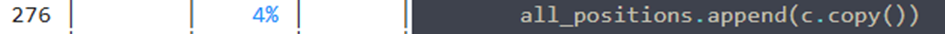

In der Simulation mit zehn Bällen wurden die Funktionen `will_collide` und `get_all_collisions` als die rechenintensivsten Teile des Codes identifiziert. Beide Funktionen berechnen den Abstand zwischen zwei Bällen mithilfe von `np.linalg.norm`, was sich als der rechenaufwändigste Teil dieser Funktionen herausstellte:
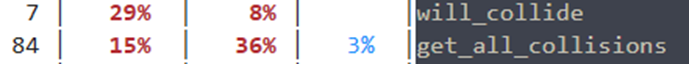

`np.linalg.norm` in `will_collide`: 

`np.linalg.norm` in `get_all_collisions`: 

Dies lässt sich dadurch erklären, dass `np.linalg.norm` bereits für sich genommen eine relativ kostspielige Operation ist, da sie die Subtraktion zweier Vektoren, das Quadrieren ihrer Komponenten, die Summation und schließlich die Quadratwurzel umfasst – alles Schritte, die zur Rechenintensität beitragen.

Darüber hinaus werden beide Funktionen in einer verschachtelten `for`-Schleife sehr häufig aufgerufen – im Prinzip für nahezu alle Ballpaare in jedem Zeitschritt, also etwa $≈\tfrac{N^2}{2}$ Mal (wobei $N$ die Anzahl der Bälle ist). Zusätzlich hat die Funktion will_collide eine eigene Schleife über das Array `k_values = [0, 0.25, 0.5, 0.75]`, was bedeutet, dass `np.linalg.norm` pro Zeitschritt vier weitere Male aufgerufen wird – also insgesamt etwa $≈4 \cdot \tfrac{N^2}{2}$ Aufrufe.

Für die Simulation mit zehn Bällen wird die Abstandsberechnung in `get_all_collisions` jedoch häufiger ausgeführt als in `will_collide`, da `get_all_collisions` wird schon dann ausgeführt, wenn die Bälle nicht maskiert sind. Die Funktion `will_collide` hingegen wird nur dann aufgerufen, wenn die Bälle nicht maskiert sind *und* sich darüber hinaus hinreichend annähern (näher als das Vierfache der Summe ihrer Radien). Erst wenn beide Bedingungen erfüllt sind, wird `will_collide` aufgerufen. Bei nur zehn Bällen ist die Anzahl möglicher Kollisionen noch zu gering, so dass die Iteration über `k_values` noch keine dominierende Rolle hat. Daher ist der Rechenaufwand von `get_all_collisions` in diesem Fall noch vergleichbar mit dem von `will_collide`.

Die Situation ändert sich drastisch bei einer Simulation mit 300 Bällen. Die höhere Anzahl an Bällen führt dazu, dass der Rechenaufwand beider Funktionen quadratisch skaliert. Gleichzeitig kommt es zu wesentlich mehr potenziellen Kollisionen (da sich mehr Bälle im selben Raum befinden), wodurch `will_collide` nahezu genauso häufig aufgerufen wird wie `get_all_collisions`. Aufgrund der zusätzlichen Schleife über `k_values` wird `will_collide` schließlich zur rechenintensivsten Funktion des gesamten Codes:

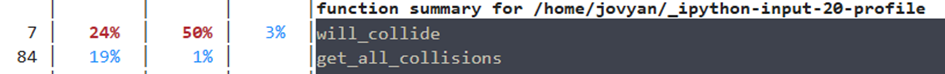

`np.linalg.norm` in `will_collide`: 

`np.linalg.norm` in `get_all_collisions`: 

Sie wird so dominant, dass der zuvor in der kollisionsfreien Simulation teuerste Codeabschnitt – das Speichern der Daten für die Visualisierung – keinen nennenswerten Anteil an den benötigten Rechenressourcen mehr hat:

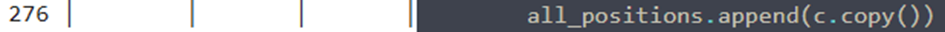

In [18]:
c, v, m, r, mask = init(10)

In [19]:
%%scalene --cpu-sampling-rate 0.01
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter


def will_collide(c1, c2, v1, v2, r1, r2, dt):
    """
    Prüft, ob zwei Bälle sich innerhalb eines Zeitschritts dt kollidieren werden

    Parameter:
    - c1, c2:   Positionen von Ball 1 und 2 
    - v1, v2:   Geschwindigkeiten von Ball 1 und 2
    - r1, r2:   Radien von Ball 1 und 2
    - dt:       Zeitschritt

    Rückgabewerte:
    - collided:                 Status: Ob eine Kollision erkannt wurde      
    - k_frac:                   Fraktion des Zeitschritts, bei dem die Kollision stattfindet
    - c1_before, c2_before:     Positionen von Ball 1 und 2 vor der Kollision
    """

    # Vorinitialisierung
    collided = False
    k_frac = 0
    c1_before = c1
    c2_before = c2
    k_values = [0, 0.25, 0.5, 0.75]  # Zeitanteile innerhalb des Zeitschritts

    for k in k_values:
        # Positionen der Bälle nach k * dt
        c1_pos = c1 + k * dt * v1
        c2_pos = c2 + k * dt * v2

        # Berechnung des Abstands zwischen den Bällen nach jedem k
        distance = np.linalg.norm(c1_pos - c2_pos)

        # Wenn Abstand kleiner als die Summe der Radien beider Bälle ist -> Kollision
        if distance < (r1 + r2):
            # Aktualisierung der Werte
            collided = True
            k_frac = k
            c1_before = c1_pos
            c2_before = c2_pos
            break  # Kollision gefunden -> Abbruch der Schleife

    return collided, k_frac, c1_before, c2_before



def collision(c1, c2, v1, v2, m1, m2):
    """
    Berechnet die elastische Kollision zwischen den Bällen 1 und 2
    
    Parameter:
    - c1, c2:   Positionen von Ball 1 und 2 
    - v1, v2:   Geschwindigkeiten von Ball 1 und 2
    - r1, r2:   Radien von Ball 1 und 2
    - m1, m2:   Massen von Ball 1 und 2
    
    Rückgabewerte:
    - v1_new, v2_new:   Neue Geschwindigkeiten von Ball 1 und 2 nach Kollision
    """
    
    # Abstand zwischen den Bällen
    r = c1 - c2
    norm_r = np.linalg.norm(r)  # Betrag des Abstandvektors
    
    # Skalarprodukt der Geschwindigkeitsdifferenz und des Positionsvektors
    v_diff = v1 - v2
    scalar_product = np.dot(v_diff, r)
    
    # Faktor für die Geschwindigkeitsänderung
    factor1 = (2 * m2) / (m1 + m2) * (scalar_product / norm_r**2)
    factor2 = (2 * m1) / (m1 + m2) * (scalar_product / norm_r**2)
    
    # Neue Geschwindigkeiten nach Kollision
    v1_new = (v1 - factor1 * r)
    v2_new = (v2 + factor2 * r)
    
    return v1_new, v2_new


def get_all_collisions(c, v, m, r, dt, mask, cooldown_frames = 4):
    """
    Prüft und behandelt alle möglichen Kollisionen zwischen Bällen
    
    Parameter:
    - c:                aktuelle Positionen von allen Bällen (Array der Form [N, 2])
    - v:                aktuelle Geschwindigkeiten von allen Bällen (Array der Form [N, 2])
    - m:                aktuelle Massen von allen Bällen (Array der Form [N, 2])
    - r:                aktuelle Radien von allen Bällen (Array der Form [N, 2])
    - dt:               Zeitschritt
    - mask:             Maske, die verhindert, dass Bälle nicht in mehreren (=cooldown_frames)  
                        aufeinanderfolgenden Zeitschritten miteinander kollidieren können
    - colldown_frames:  Anzahl der Zeitschritte, bis die Bälle nach einer Kollision
                        wieder für die Berechnung der nächsten Kollision berücksichtigt werden können
    
    Rückgabewerte:
    - c:    Neue Positionen der Bälle nach Kollisionen
    - v:    Neue Geschwindigkeiten der Bälle nach Kollisionen
    - mask: Aktualisierte Maske
    """
    
    N = len(c) # Anzahl der Bälle

    for i in range(N):
        for j in range(i + 1, N):
            
            # Prüfe, ob die Bälle maskiert sind
            if mask[i, j] > 0:
                continue  # Maske anwenden -> Kollision wird nicht überprüft

            # Prüfe, ob die Bälle nah genug sind
            distance = np.linalg.norm(c[i] - c[j])
            min_dist = r[i] + r[j]
            if distance >= 4 * min_dist:
                continue  # Bälle sind noch zu weit voneinander -> Kollision wird nicht überprüft
            
            # Prüfe ob die Kollision schon in diesem Zeitschritt stattfindet
            collided, k_frac, c1_before, c2_before = will_collide(c[i], c[j], v[i], v[j], r[i], r[j], dt)

            if collided:
                # Wenn Kollision, dann neue Geschwindigkeiten
                v1_new, v2_new = collision(c[i], c[j], v[i], v[j], m[i], m[j])
      
                # Neue Position nach der Kollision berechnen 
                c[i] = c1_before + v1_new * (1 - k_frac) * dt # neue Position für Ball 1
                c[j] = c2_before + v2_new * (1 - k_frac) * dt # neue Position für Ball 2
                
                # Aktualisierung von v 
                v[i] = v1_new
                v[j] = v2_new
                
                # Aktualisierung der Maske, wenn Kollisionen aufgetreten sind
                mask[i, j] = cooldown_frames
                mask[j, i] = cooldown_frames                
    
    # Aktualisierung der Maske, wenn keine Kollisionen aufgetreten sind
    mask = np.maximum(mask - 1, 0)
    
    return c, v, mask


def timestep_with_collisions(c, v, m, dt, g, r, xmax, ymax, mask):
    """
    Führt einen vollständigen Zeitschritt mit Kollisionen durch
    
    Parameter:
    - c:                aktuelle Positionen von allen Bällen (Array der Form [N, 2])
    - v:                aktuelle Geschwindigkeiten von allen Bällen (Array der Form [N, 2])
    - m:                aktuelle Massen von allen Bällen (Array der Form [N, 2])
    - dt:               Zeitschritt
    - g:                Gravitationsvektor
    - r:                aktuelle Radien von allen Bällen (Array der Form [N, 2])
    - xmax, ymax:       Begrenzung des Simulationsraums
    - mask:             Maske, die verhindert, dass Bälle nicht in mehreren (=cooldown_frames)  
                        aufeinanderfolgenden Zeitschritten miteinander kollidieren können

    
    Rückgabewerte:
    - c:    Neue Positionen der Bälle nach dt
    - v:    Neue Geschwindigkeiten der Bälle nach dt
    - mask: Aktualisierte Maske
    """
    
    # Gravitation anwenden
    v = v + g * dt
    c += v * dt

    # Kollisionen zwischen Bällen berechnen
    c, v, mask = get_all_collisions(c, v, m, r, dt, mask)

    # Wandkollisionen behandeln (links/rechts)
    left_wall = c[:, 0] <= 0 
    right_wall = c[:, 0] >= xmax 
    if np.any(left_wall | right_wall):
        dt2_left_wall = abs(c[left_wall, 0]) / abs(v[left_wall, 0]) 
        dt2_right_wall = (abs(c[right_wall,0]) - xmax) / abs(v[right_wall, 0]) 
        v[left_wall | right_wall, 0] *= -1 
        c[left_wall, 0] = dt2_left_wall * v[left_wall, 0] 
        c[right_wall, 0] = xmax - dt2_right_wall * v[right_wall, 0] 
    # Wandkollisionen (oben/unten)
    bottom = c[:, 1] <= 0
    top = c[:, 1] >= ymax
    if np.any(bottom | top):
        dt2_bottom = abs(c[bottom, 1]) / abs(v[bottom, 1])
        dt2_top = (abs(c[top, 1]) - ymax) / abs(v[top, 1])
        v[bottom | top, 1] *= -1
        c[bottom, 1] = dt2_bottom * v[bottom, 1]
        c[top, 1] = ymax - dt2_top * v[top, 1]

    return c, v, mask


# Erstellt eine animierte Visualisierung der Positionen
def animate_positions(all_positions, num_balls, xmax, ymax, r, m, filename="multi_ball_collisions.gif"):
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation, PillowWriter
    from matplotlib.patches import Circle
    import numpy as np

    print ("GIF wird erstellt...")
    colors = plt.cm.jet(np.linspace(0, 1, num_balls))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, xmax)
    ax.set_ylim(0, ymax)
    ax.set_aspect('equal')
    ax.set_title("Simulation: Springende Bälle mit Kollisionen")

    # Bälle erstellen
    circles = []
    for i in range(num_balls):
        circle = Circle((0, 0), r[i], color=colors[i])
        ax.add_patch(circle)
        circles.append(circle)

    def init():
        for circle in circles:
            circle.center = (-10, -10) # Anfangs außerhalb des Bildes
        return circles

    def update(frame):
        positions = all_positions[frame]
        for i, circle in enumerate(circles):
            circle.center = positions[i]
        return circles

    ani = FuncAnimation(fig, update, frames=len(all_positions), init_func=init, blit=True, interval=50)
    ani.save(filename, writer=PillowWriter(fps=20))
    print(f"GIF gespeichert als: {filename}")

    
# Anfangsbedingungen
g = np.array([0, -9.81], dtype=np.float64)
xmax = 100
ymax = 100
steps = 1000
# dt = xmax * 1e-5
dt = 0.1

# Anzahl Bälle
N = 10

rng = np.random.default_rng(seed=123)

# Flag zur Aktivierung der Visualisierung (Trennung der Simulation und Visualisierung)
visualize = True

# Startpositionen
def init(n=N):
    c = xmax * rng.random((N, 2))
    # Startgeschwindigkeiten, max.
    v = np.array([xmax/10, ymax/10]) * rng.random((N, 2))
    # Masse
    m = rng.uniform(5, 15, size=N)
    r = np.sqrt(m) 
    mask = np.full((N, N), 0, np.int32)
    return c, v, m, r, mask

    
# ------------------------------
# HAUPTFUNKTION
# ------------------------------   

# Initialisierung 
# c, v, m, r, mask = init()

if visualize == True:
    # Führe Simulation mit Visualisierung durch und animiere das Ergebnis
    all_positions = [c.copy()]

    for i in range(steps):
        c, v, mask = timestep_with_collisions(c, v, m, dt, g, r, xmax, ymax, mask)
        all_positions.append(c.copy())
    print("Simulation (mit Visualisierung) war erfolgreich")
else:
    # Nur reine Simulation ohne Visualisierung
    for i in range(steps):
        timestep_with_collisions(c, v, m, dt, g, r, xmax, ymax, mask)
    print("Simulation (ohne Visualisierung) war erfolgreich")

Simulation (mit Visualisierung) war erfolgreich
,                     /home/jovyan/_ipython-input-18-profile: % of time = 100.00% (812.707ms) out of 812.707ms.                     
,        ╷        ╷       ╷       ╷                                                                                                 
,        │Time    │–––––– │–––––– │                                                                                                 
,  Line  │Python  │native │system │/home/jovyan/_ipython-input-18-profile                                                           
,╺━━━━━━━┿━━━━━━━━┿━━━━━━━┿━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸
,      1 │        │       │       │                                                                                                 
,      2 │        │       │       │import numpy as np                                                                               
,      3 │        │  

In [20]:
c, v, m, r, mask = init(300)

In [21]:
%%scalene --cpu-sampling-rate 0.01
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter


def will_collide(c1, c2, v1, v2, r1, r2, dt):
    """
    Prüft, ob zwei Bälle sich innerhalb eines Zeitschritts dt kollidieren werden

    Parameter:
    - c1, c2:   Positionen von Ball 1 und 2 
    - v1, v2:   Geschwindigkeiten von Ball 1 und 2
    - r1, r2:   Radien von Ball 1 und 2
    - dt:       Zeitschritt

    Rückgabewerte:
    - collided:                 Status: Ob eine Kollision erkannt wurde      
    - k_frac:                   Fraktion des Zeitschritts, bei dem die Kollision stattfindet
    - c1_before, c2_before:     Positionen von Ball 1 und 2 vor der Kollision
    """

    # Vorinitialisierung
    collided = False
    k_frac = 0
    c1_before = c1
    c2_before = c2
    k_values = [0, 0.25, 0.5, 0.75]  # Zeitanteile innerhalb des Zeitschritts

    for k in k_values:
        # Positionen der Bälle nach k * dt
        c1_pos = c1 + k * dt * v1
        c2_pos = c2 + k * dt * v2

        # Berechnung des Abstands zwischen den Bällen nach jedem k
        distance = np.linalg.norm(c1_pos - c2_pos)

        # Wenn Abstand kleiner als die Summe der Radien beider Bälle ist -> Kollision
        if distance < (r1 + r2):
            # Aktualisierung der Werte
            collided = True
            k_frac = k
            c1_before = c1_pos
            c2_before = c2_pos
            break  # Kollision gefunden -> Abbruch der Schleife

    return collided, k_frac, c1_before, c2_before



def collision(c1, c2, v1, v2, m1, m2):
    """
    Berechnet die elastische Kollision zwischen den Bällen 1 und 2
    
    Parameter:
    - c1, c2:   Positionen von Ball 1 und 2 
    - v1, v2:   Geschwindigkeiten von Ball 1 und 2
    - r1, r2:   Radien von Ball 1 und 2
    - m1, m2:   Massen von Ball 1 und 2
    
    Rückgabewerte:
    - v1_new, v2_new:   Neue Geschwindigkeiten von Ball 1 und 2 nach Kollision
    """
    
    # Abstand zwischen den Bällen
    r = c1 - c2
    norm_r = np.linalg.norm(r)  # Betrag des Abstandvektors
    
    # Skalarprodukt der Geschwindigkeitsdifferenz und des Positionsvektors
    v_diff = v1 - v2
    scalar_product = np.dot(v_diff, r)
    
    # Faktor für die Geschwindigkeitsänderung
    factor1 = (2 * m2) / (m1 + m2) * (scalar_product / norm_r**2)
    factor2 = (2 * m1) / (m1 + m2) * (scalar_product / norm_r**2)
    
    # Neue Geschwindigkeiten nach Kollision
    v1_new = (v1 - factor1 * r)
    v2_new = (v2 + factor2 * r)
    
    return v1_new, v2_new


def get_all_collisions(c, v, m, r, dt, mask, cooldown_frames = 4):
    """
    Prüft und behandelt alle möglichen Kollisionen zwischen Bällen
    
    Parameter:
    - c:                aktuelle Positionen von allen Bällen (Array der Form [N, 2])
    - v:                aktuelle Geschwindigkeiten von allen Bällen (Array der Form [N, 2])
    - m:                aktuelle Massen von allen Bällen (Array der Form [N, 2])
    - r:                aktuelle Radien von allen Bällen (Array der Form [N, 2])
    - dt:               Zeitschritt
    - mask:             Maske, die verhindert, dass Bälle nicht in mehreren (=cooldown_frames)  
                        aufeinanderfolgenden Zeitschritten miteinander kollidieren können
    - colldown_frames:  Anzahl der Zeitschritte, bis die Bälle nach einer Kollision
                        wieder für die Berechnung der nächsten Kollision berücksichtigt werden können
    
    Rückgabewerte:
    - c:    Neue Positionen der Bälle nach Kollisionen
    - v:    Neue Geschwindigkeiten der Bälle nach Kollisionen
    - mask: Aktualisierte Maske
    """
    
    N = len(c) # Anzahl der Bälle

    for i in range(N):
        for j in range(i + 1, N):
            
            # Prüfe, ob die Bälle maskiert sind
            if mask[i, j] > 0:
                continue  # Maske anwenden -> Kollision wird nicht überprüft

            # Prüfe, ob die Bälle nah genug sind
            distance = np.linalg.norm(c[i] - c[j])
            min_dist = r[i] + r[j]
            if distance >= 4 * min_dist:
                continue  # Bälle sind noch zu weit voneinander -> Kollision wird nicht überprüft
            
            # Prüfe ob die Kollision schon in diesem Zeitschritt stattfindet
            collided, k_frac, c1_before, c2_before = will_collide(c[i], c[j], v[i], v[j], r[i], r[j], dt)

            if collided:
                # Wenn Kollision, dann neue Geschwindigkeiten
                v1_new, v2_new = collision(c[i], c[j], v[i], v[j], m[i], m[j])
      
                # Neue Position nach der Kollision berechnen 
                c[i] = c1_before + v1_new * (1 - k_frac) * dt # neue Position für Ball 1
                c[j] = c2_before + v2_new * (1 - k_frac) * dt # neue Position für Ball 2
                
                # Aktualisierung von v 
                v[i] = v1_new
                v[j] = v2_new
                
                # Aktualisierung der Maske, wenn Kollisionen aufgetreten sind
                mask[i, j] = cooldown_frames
                mask[j, i] = cooldown_frames                
    
    # Aktualisierung der Maske, wenn keine Kollisionen aufgetreten sind
    mask = np.maximum(mask - 1, 0)
    
    return c, v, mask


def timestep_with_collisions(c, v, m, dt, g, r, xmax, ymax, mask):
    """
    Führt einen vollständigen Zeitschritt mit Kollisionen durch
    
    Parameter:
    - c:                aktuelle Positionen von allen Bällen (Array der Form [N, 2])
    - v:                aktuelle Geschwindigkeiten von allen Bällen (Array der Form [N, 2])
    - m:                aktuelle Massen von allen Bällen (Array der Form [N, 2])
    - dt:               Zeitschritt
    - g:                Gravitationsvektor
    - r:                aktuelle Radien von allen Bällen (Array der Form [N, 2])
    - xmax, ymax:       Begrenzung des Simulationsraums
    - mask:             Maske, die verhindert, dass Bälle nicht in mehreren (=cooldown_frames)  
                        aufeinanderfolgenden Zeitschritten miteinander kollidieren können

    
    Rückgabewerte:
    - c:    Neue Positionen der Bälle nach dt
    - v:    Neue Geschwindigkeiten der Bälle nach dt
    - mask: Aktualisierte Maske
    """
    
    # Gravitation anwenden
    v = v + g * dt
    c += v * dt

    # Kollisionen zwischen Bällen berechnen
    c, v, mask = get_all_collisions(c, v, m, r, dt, mask)

    # Wandkollisionen behandeln (links/rechts)
    left_wall = c[:, 0] <= 0 
    right_wall = c[:, 0] >= xmax 
    if np.any(left_wall | right_wall):
        dt2_left_wall = abs(c[left_wall, 0]) / abs(v[left_wall, 0]) 
        dt2_right_wall = (abs(c[right_wall,0]) - xmax) / abs(v[right_wall, 0]) 
        v[left_wall | right_wall, 0] *= -1 
        c[left_wall, 0] = dt2_left_wall * v[left_wall, 0] 
        c[right_wall, 0] = xmax - dt2_right_wall * v[right_wall, 0] 
    # Wandkollisionen (oben/unten)
    bottom = c[:, 1] <= 0
    top = c[:, 1] >= ymax
    if np.any(bottom | top):
        dt2_bottom = abs(c[bottom, 1]) / abs(v[bottom, 1])
        dt2_top = (abs(c[top, 1]) - ymax) / abs(v[top, 1])
        v[bottom | top, 1] *= -1
        c[bottom, 1] = dt2_bottom * v[bottom, 1]
        c[top, 1] = ymax - dt2_top * v[top, 1]

    return c, v, mask


# Erstellt eine animierte Visualisierung der Positionen
def animate_positions(all_positions, num_balls, xmax, ymax, r, m, filename="multi_ball_collisions.gif"):
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation, PillowWriter
    from matplotlib.patches import Circle
    import numpy as np

    print ("GIF wird erstellt...")
    colors = plt.cm.jet(np.linspace(0, 1, num_balls))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, xmax)
    ax.set_ylim(0, ymax)
    ax.set_aspect('equal')
    ax.set_title("Simulation: Springende Bälle mit Kollisionen")

    # Bälle erstellen
    circles = []
    for i in range(num_balls):
        circle = Circle((0, 0), r[i], color=colors[i])
        ax.add_patch(circle)
        circles.append(circle)

    def init():
        for circle in circles:
            circle.center = (-10, -10) # Anfangs außerhalb des Bildes
        return circles

    def update(frame):
        positions = all_positions[frame]
        for i, circle in enumerate(circles):
            circle.center = positions[i]
        return circles

    ani = FuncAnimation(fig, update, frames=len(all_positions), init_func=init, blit=True, interval=50)
    ani.save(filename, writer=PillowWriter(fps=20))
    print(f"GIF gespeichert als: {filename}")

    
# Anfangsbedingungen
g = np.array([0, -9.81], dtype=np.float64)
xmax = 100
ymax = 100
steps = 1000
# dt = xmax * 1e-5
dt = 0.1

# Anzahl Bälle
N = 10

rng = np.random.default_rng(seed=123)

# Flag zur Aktivierung der Visualisierung (Trennung der Simulation und Visualisierung)
visualize = True

# Startpositionen
def init(n=N):
    c = xmax * rng.random((N, 2))
    # Startgeschwindigkeiten, max.
    v = np.array([xmax/10, ymax/10]) * rng.random((N, 2))
    # Masse
    m = rng.uniform(5, 15, size=N)
    r = np.sqrt(m) 
    mask = np.full((N, N), 0, np.int32)
    return c, v, m, r, mask

    
# ------------------------------
# HAUPTFUNKTION
# ------------------------------   

# Initialisierung 
# c, v, m, r, mask = init()

if visualize == True:
    # Führe Simulation mit Visualisierung durch und animiere das Ergebnis
    all_positions = [c.copy()]

    for i in range(steps):
        c, v, mask = timestep_with_collisions(c, v, m, dt, g, r, xmax, ymax, mask)
        all_positions.append(c.copy())
    print("Simulation (mit Visualisierung) war erfolgreich")
else:
    # Nur reine Simulation ohne Visualisierung
    for i in range(steps):
        timestep_with_collisions(c, v, m, dt, g, r, xmax, ymax, mask)
    print("Simulation (ohne Visualisierung) war erfolgreich")

Simulation (mit Visualisierung) war erfolgreich
,                     /home/jovyan/_ipython-input-20-profile: % of time = 100.00% (836.110ms) out of 836.110ms.                     
,        ╷        ╷       ╷       ╷                                                                                                 
,        │Time    │–––––– │–––––– │                                                                                                 
,  Line  │Python  │native │system │/home/jovyan/_ipython-input-20-profile                                                           
,╺━━━━━━━┿━━━━━━━━┿━━━━━━━┿━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸
,      1 │        │       │       │                                                                                                 
,      2 │        │       │       │import numpy as np                                                                               
,      3 │        │  

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Aufgabe:** Versuchen Sie Ihren Code (d.h. `timestep_with_collisions`) zu optimieren, damit er besser skaliert.

Vergleichen Sie danach die Ausführungszeiten beider Varianten für 20 Zeitschritte mit $[100, 200,300]$ Bällen.

Stellen Sie den Vergleich graphisch dar.

_Points:_ 10

In [8]:
## Optimized CODE
from numba import njit, prange
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# ------------------------------
# OPTIMIERUNG DER FUNKTION WILL_COLLIDE
# ------------------------------
# optimisiert
@njit
def will_collide_numba(c1, c2, v1, v2, r1, r2, dt):
    
    collided = False
    k_frac = 0
    c1_before = c1
    c2_before = c2
    k_values = [0, 0.25, 0.5, 0.75]  

    for k in k_values:
        c1_pos = c1 + k * dt * v1
        c2_pos = c2 + k * dt * v2

        distance = np.linalg.norm(c1_pos - c2_pos)

        if distance < (r1 + r2):
            collided = True
            k_frac = k
            c1_before = c1_pos
            c2_before = c2_pos
            break  

    return collided, k_frac, c1_before, c2_before
    
# ------------------------------
# OPTIMIERUNG DER FUNKTION COLLISION
# ------------------------------
# optimisiert
@njit
def collision_numba(c1, c2, v1, v2, m1, m2):

    r = c1 - c2
    norm_r = np.linalg.norm(r)  
    
    v_diff = v1 - v2
    scalar_product = np.dot(v_diff, r)
    
    factor1 = (2 * m2) / (m1 + m2) * (scalar_product / norm_r**2)
    factor2 = (2 * m1) / (m1 + m2) * (scalar_product / norm_r**2)
    
    v1_new = (v1 - factor1 * r)
    v2_new = (v2 + factor2 * r)
    
    return v1_new, v2_new

# ------------------------------
# OPTIMIERUNG FUNKTION GET_ALL_COLLISIONS
# ------------------------------
# optimisiert
@njit
def get_all_collisions_numba(c, v, m, r, dt, mask, cooldown_frames = 4):
    
    N = len(c)

    for i in prange(N): # parallele Ausführung der for-Schleife
        for j in range(i + 1, N): 
            if mask[i, j] > 0:
                continue  

            distance = np.linalg.norm(c[i] - c[j])
            min_dist = r[i] + r[j]
            if distance >= 4 * min_dist:
                continue  
            
            collided, k_frac, c1_before, c2_before = will_collide_numba(c[i], c[j], v[i], v[j], r[i], r[j], dt)

            if collided:
                v1_new, v2_new = collision_numba(c[i], c[j], v[i], v[j], m[i], m[j])
      
                c[i] = c1_before + v1_new * (1 - k_frac) * dt 
                c[j] = c2_before + v2_new * (1 - k_frac) * dt 
               
                v[i] = v1_new
                v[j] = v2_new
                              
                mask[i, j] = cooldown_frames
                mask[j, i] = cooldown_frames                

    mask = np.maximum(mask - 1, 0)
    
    return c, v, mask

# ------------------------------
# OPTIMIERUNG DER FUNKTION TIMESTEP_WITH_COLLISIONS
# ------------------------------
# optimisiert
@njit
def timestep_with_collisions_numba(c, v, m, dt, g, r, xmax, ymax, mask):

    v = v + g * dt
    c += v * dt

    c, v, mask = get_all_collisions_numba(c, v, m, r, dt, mask)

    left_wall = c[:, 0] <= 0 
    right_wall = c[:, 0] >= xmax 
    if np.any(left_wall | right_wall):
        dt2_left_wall = np.abs(c[left_wall, 0]) / np.abs(v[left_wall, 0]) 
        dt2_right_wall = (np.abs(c[right_wall,0]) - xmax) / np.abs(v[right_wall, 0]) 
        v[left_wall | right_wall, 0] *= -1 
        c[left_wall, 0] = dt2_left_wall * v[left_wall, 0] 
        c[right_wall, 0] = xmax - dt2_right_wall * v[right_wall, 0] 

    bottom = c[:, 1] <= 0
    top = c[:, 1] >= ymax
    if np.any(bottom | top):
        dt2_bottom = np.abs(c[bottom, 1]) / np.abs(v[bottom, 1])
        dt2_top = (np.abs(c[top, 1]) - ymax) / np.abs(v[top, 1])
        v[bottom | top, 1] *= -1
        c[bottom, 1] = dt2_bottom * v[bottom, 1]
        c[top, 1] = ymax - dt2_top * v[top, 1]

    return c, v, mask

In [12]:
# Anfangsbedingungen
g = np.array([0, -9.81], dtype=np.float64)
xmax = 100
ymax = 100
steps = 1000
# dt = xmax * 1e-5
dt = 0.1

# Anzahl Bälle
N = 10

rng = np.random.default_rng(seed=123)

# Flag zur Aktivierung der Visualisierung (Trennung der Simulation und Visualisierung)
visualize = False
# Startpositionen
def init(n=N):
    c = xmax * rng.random((N, 2))
    # Startgeschwindigkeiten, max.
    v = np.array([xmax/10, ymax/10]) * rng.random((N, 2))
    # Masse
    m = rng.uniform(5, 15, size=N)
    r = np.sqrt(m) 
    mask = np.full((N, N), 0, np.int32)
    return c, v, m, r, mask
    
c, v, m, r, mask = init()

if visualize == True:
    # Führe Simulation mit Visualisierung durch und animiere das Ergebnis
    all_positions = [c.copy()]

    for i in range(steps):
        c, v, mask = timestep_with_collisions_numba(c, v, m, dt, g, r, xmax, ymax, mask)
        all_positions.append(c.copy())
    
    print("Numba-optimierte Simulation (mit Visualisierung) war erfolgreich")
else:
    # Nur reine Simulation ohne Visualisierung
    for i in range(steps):
        timestep_with_collisions_numba(c, v, m, dt, g, r, xmax, ymax, mask)
    print("Numba-optimierte Simulation (ohne Visualisierung) war erfolgreich")

Numba-optimierte Simulation (ohne Visualisierung) war erfolgreich


Numba  (100 balls): 0.079 s
Python (100 balls): 1.141 s
Numba  (200 balls): 0.304 s
Python (200 balls): 4.254 s
Numba  (300 balls): 0.707 s
Python (300 balls): 11.383 s


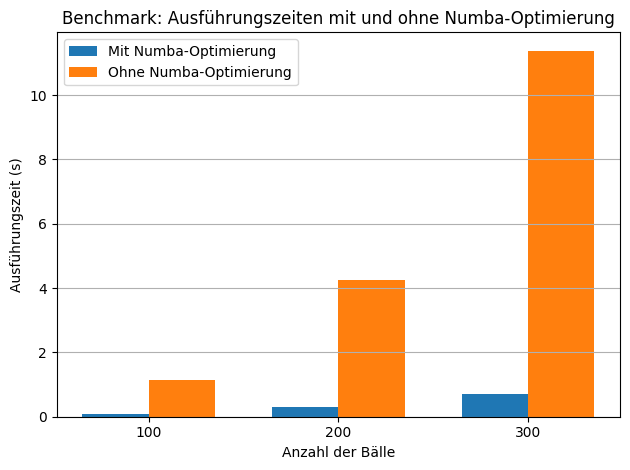

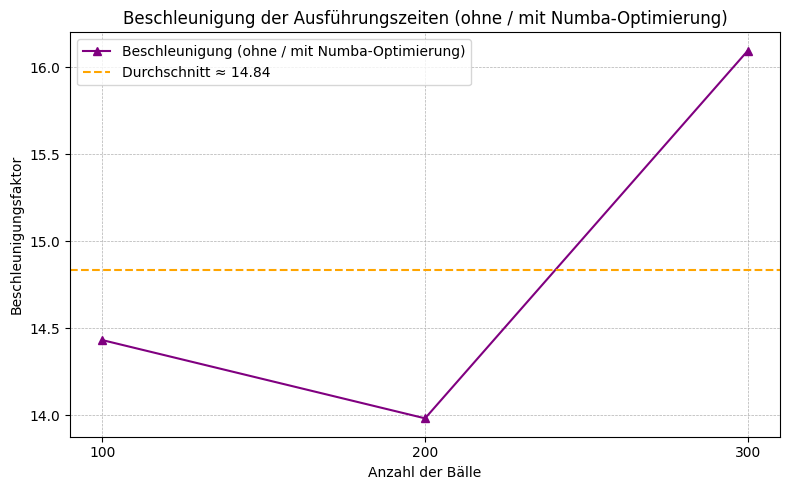

In [16]:
# Benchmark der Ausführungszeiten mit und ohne Numba-Optimierung
# Graphische Darstellung der Ergebnisse

from numba import njit, prange
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import timeit

# ------------------------------
# OPTIMIERUNG DER FUNKTION WILL_COLLIDE
# ------------------------------
# optimisiert
@njit
def will_collide_numba(c1, c2, v1, v2, r1, r2, dt):
    
    collided = False
    k_frac = 0
    c1_before = c1
    c2_before = c2
    k_values = [0, 0.25, 0.5, 0.75]  

    for k in k_values:
        c1_pos = c1 + k * dt * v1
        c2_pos = c2 + k * dt * v2

        distance = np.linalg.norm(c1_pos - c2_pos)

        if distance < (r1 + r2):
            collided = True
            k_frac = k
            c1_before = c1_pos
            c2_before = c2_pos
            break  

    return collided, k_frac, c1_before, c2_before

# Original    
def will_collide(c1, c2, v1, v2, r1, r2, dt):
    
    collided = False
    k_frac = 0
    c1_before = c1
    c2_before = c2
    k_values = [0, 0.25, 0.5, 0.75]  

    for k in k_values:
        c1_pos = c1 + k * dt * v1
        c2_pos = c2 + k * dt * v2

        distance = np.linalg.norm(c1_pos - c2_pos)

        if distance < (r1 + r2):
            collided = True
            k_frac = k
            c1_before = c1_pos
            c2_before = c2_pos
            break 

    return collided, k_frac, c1_before, c2_before


# ------------------------------
# OPTIMIERUNG DER FUNKTION COLLISION
# ------------------------------
# optimisiert
@njit
def collision_numba(c1, c2, v1, v2, m1, m2):

    r = c1 - c2
    norm_r = np.linalg.norm(r)  
    
    v_diff = v1 - v2
    scalar_product = np.dot(v_diff, r)
    
    factor1 = (2 * m2) / (m1 + m2) * (scalar_product / norm_r**2)
    factor2 = (2 * m1) / (m1 + m2) * (scalar_product / norm_r**2)
    
    v1_new = (v1 - factor1 * r)
    v2_new = (v2 + factor2 * r)
    
    return v1_new, v2_new
    
# Original    
def collision(c1, c2, v1, v2, m1, m2):

    r = c1 - c2
    norm_r = np.linalg.norm(r)  
    
    v_diff = v1 - v2
    scalar_product = np.dot(v_diff, r)
    
    factor1 = (2 * m2) / (m1 + m2) * (scalar_product / norm_r**2)
    factor2 = (2 * m1) / (m1 + m2) * (scalar_product / norm_r**2)
    
    v1_new = (v1 - factor1 * r)
    v2_new = (v2 + factor2 * r)
    
    return v1_new, v2_new
    
# ------------------------------
# OPTIMIERUNG FUNKTION GET_ALL_COLLISIONS
# ------------------------------
# optimisiert
@njit
def get_all_collisions_numba(c, v, m, r, dt, mask, cooldown_frames = 4):
    
    N = len(c)

    for i in prange(N): # parallele Ausführung der for-Schleife
        for j in range(i + 1, N): 
            if mask[i, j] > 0:
                continue  

            distance = np.linalg.norm(c[i] - c[j])
            min_dist = r[i] + r[j]
            if distance >= 4 * min_dist:
                continue  
            
            collided, k_frac, c1_before, c2_before = will_collide_numba(c[i], c[j], v[i], v[j], r[i], r[j], dt)

            if collided:
                v1_new, v2_new = collision_numba(c[i], c[j], v[i], v[j], m[i], m[j])
      
                c[i] = c1_before + v1_new * (1 - k_frac) * dt 
                c[j] = c2_before + v2_new * (1 - k_frac) * dt 
               
                v[i] = v1_new
                v[j] = v2_new
                              
                mask[i, j] = cooldown_frames
                mask[j, i] = cooldown_frames                

    mask = np.maximum(mask - 1, 0)
    
    return c, v, mask
    

# Original    
def get_all_collisions(c, v, m, r, dt, mask, cooldown_frames = 4):
    
    N = len(c)

    for i in range(N):
        for j in range(i + 1, N):
            if mask[i, j] > 0:
                continue  

            distance = np.linalg.norm(c[i] - c[j])
            min_dist = r[i] + r[j]
            if distance >= 4 * min_dist:
                continue  
            
            collided, k_frac, c1_before, c2_before = will_collide(c[i], c[j], v[i], v[j], r[i], r[j], dt)

            if collided:
                v1_new, v2_new = collision(c[i], c[j], v[i], v[j], m[i], m[j])
      
                c[i] = c1_before + v1_new * (1 - k_frac) * dt 
                c[j] = c2_before + v2_new * (1 - k_frac) * dt 
               
                v[i] = v1_new
                v[j] = v2_new
                
                mask[i, j] = cooldown_frames
                mask[j, i] = cooldown_frames                

    mask = np.maximum(mask - 1, 0)
    
    return c, v, mask

# ------------------------------
# OPTIMIERUNG DER FUNKTION TIMESTEP_WITH_COLLISIONS
# ------------------------------
# optimisiert
@njit
def timestep_with_collisions_numba(c, v, m, dt, g, r, xmax, ymax, mask):

    v = v + g * dt
    c += v * dt

    c, v, mask = get_all_collisions_numba(c, v, m, r, dt, mask)

    left_wall = c[:, 0] <= 0 
    right_wall = c[:, 0] >= xmax 
    if np.any(left_wall | right_wall):
        dt2_left_wall = np.abs(c[left_wall, 0]) / np.abs(v[left_wall, 0]) 
        dt2_right_wall = (np.abs(c[right_wall,0]) - xmax) / np.abs(v[right_wall, 0]) 
        v[left_wall | right_wall, 0] *= -1 
        c[left_wall, 0] = dt2_left_wall * v[left_wall, 0] 
        c[right_wall, 0] = xmax - dt2_right_wall * v[right_wall, 0] 

    bottom = c[:, 1] <= 0
    top = c[:, 1] >= ymax
    if np.any(bottom | top):
        dt2_bottom = np.abs(c[bottom, 1]) / np.abs(v[bottom, 1])
        dt2_top = (np.abs(c[top, 1]) - ymax) / np.abs(v[top, 1])
        v[bottom | top, 1] *= -1
        c[bottom, 1] = dt2_bottom * v[bottom, 1]
        c[top, 1] = ymax - dt2_top * v[top, 1]

    return c, v, mask
    
# Original   
def timestep_with_collisions(c, v, m, dt, g, r, xmax, ymax, mask):

    v = v + g * dt
    c += v * dt

    c, v, mask = get_all_collisions(c, v, m, r, dt, mask)

    left_wall = c[:, 0] <= 0 
    right_wall = c[:, 0] >= xmax 
    if np.any(left_wall | right_wall):
        dt2_left_wall = np.abs(c[left_wall, 0]) / np.abs(v[left_wall, 0])
        dt2_right_wall = (np.abs(c[right_wall,0]) - xmax) / np.abs(v[right_wall, 0]) 
        v[left_wall | right_wall, 0] *= -1 
        c[left_wall, 0] = dt2_left_wall * v[left_wall, 0] 
        c[right_wall, 0] = xmax - dt2_right_wall * v[right_wall, 0] 

    bottom = c[:, 1] <= 0
    top = c[:, 1] >= ymax
    if np.any(bottom | top):
        dt2_bottom = np.abs(c[bottom, 1]) / np.abs(v[bottom, 1])
        dt2_top = (np.abs(c[top, 1]) - ymax) / np.abs(v[top, 1])
        v[bottom | top, 1] *= -1
        c[bottom, 1] = dt2_bottom * v[bottom, 1]
        c[top, 1] = ymax - dt2_top * v[top, 1]

    return c, v, mask


# ------------------------------
# VISUALISIERUNG
# ------------------------------
def animate_positions(all_positions, num_balls, xmax, ymax, r, m, filename="multi_ball_collisions.gif"):
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation, PillowWriter
    from matplotlib.patches import Circle
    import numpy as np

    print ("GIF wird erstellt...")
    colors = plt.cm.jet(np.linspace(0, 1, num_balls))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, xmax)
    ax.set_ylim(0, ymax)
    ax.set_aspect('equal')
    ax.set_title("Simulation: Springende Baelle mit Kollisionen")


    circles = []
    for i in range(num_balls):
        circle = Circle((0, 0), r[i], color=colors[i])
        ax.add_patch(circle)
        circles.append(circle)

    def init():
        for circle in circles:
            circle.center = (-10, -10)  
        return circles

    def update(frame):
        positions = all_positions[frame]
        for i, circle in enumerate(circles):
            circle.center = positions[i]
        return circles

    ani = FuncAnimation(fig, update, frames=len(all_positions), init_func=init, blit=True, interval=50)
    ani.save(filename, writer=PillowWriter(fps=20))
    print(f"GIF gespeichert als: {filename}")


# ------------------------------
# INITIALISIERUNG UND BENCHMARK
# ------------------------------

# Startpositionen
def init(N, xmax, ymax, rng):
    c = xmax * rng.random((N, 2))
    v = np.array([xmax/10, ymax/10]) * rng.random((N, 2))
    m = rng.uniform(5, 15, size=N)
    r = np.sqrt(m) 
    mask = np.full((N, N), 0, np.int32)
    return c, v, m, r, mask
    
   
def benchmark(num_balls_list):
    """
    Vergleicht die Ausführungszeiten der Simulation mit und ohne Numba-Optimierung
    
    Paramter:
    - num_balls_list:   Liste mit der Anzahl der Bälle für die Simulation
    
    Rückgabewerte:
    - times_numba:      Ausführungszeiten mit Numba-Optimierung
    - times_python:     Ausführungszeiten ohne Numba-Optimierung
    """
    # Listen zur Speicherung der Ausführungszeiten für Numba- und Python-Versionen
    times_numba = []
    times_python = []
    
    # Allgemeine Simulationsparameter
    g = np.array([0, -9.81], dtype=np.float64)
    xmax = 100
    ymax = 100
    steps = 20
    dt = 0.1
    rng = np.random.default_rng(seed=123)
    
    # Iteration über die Liste mit der Anzahl der Bälle
    for i, N in enumerate(num_balls_list):
        # Initialisiere Positionen, Geschwindigkeiten, Massen, Radien und Kollisionsmaske
        c, v, m, r, mask = init(N, xmax, ymax, rng)
        
        # Definition einer Hilfsfunktion, die die Numba-Version für N Schritte ausführt
        def run_numba():
            c_numba, v_numba, mask_numba = c.copy(), v.copy(), mask.copy() # Kopien für unabhängige Ausführung
            for _ in range(steps):
                c_numba, v_numba, mask_numba = timestep_with_collisions_numba(c_numba, v_numba, m, dt, g, r, xmax, ymax, mask_numba)
        
        # Definition einer Hilfsfunktion, die die Python-Version für N Schritte ausführt
        def run_python():
            c_py, v_py, mask_py = c.copy(), v.copy(), mask.copy() # Kopien für unabhängige Ausführung
            for _ in range(steps):
                c_py, v_py, mask_py = timestep_with_collisions(c_py, v_py, m, dt, g, r, xmax, ymax, mask_py)
        
        # Zeitmessung der Numba- und Python-Versionen mit timeit 
        t_numba = timeit.timeit(run_numba, number=1)
        t_python = timeit.timeit(run_python, number=1)
        
        # Speichere gemessene Zeiten
        times_numba.append(t_numba)
        times_python.append(t_python)
        
        # Ausgabe der Laufzeiten
        if i > 0: # Überspringen die Laufzeiten für Warm-up
            print(f"Numba  ({N} balls): {t_numba:.3f} s")
            print(f"Python ({N} balls): {t_python:.3f} s")

    return times_numba, times_python

# Benchmark-Liste mit der Anzahl der Bälle
original_list = [100, 200, 300]
# Der erste Wert doppelt (für Numba-Warmup)
num_balls_list = [original_list[0]] + original_list  # -> [100, 100, 200, 300]

# Starte Benchmark
times_numba, times_python = benchmark(num_balls_list)


# ------------------------------
# VISUALISIERUNG DER LAUFZEITEN
# ------------------------------
# Balkendiagramm
x = np.arange(len(original_list))  
width = 0.35  

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, times_numba[1:], width, label='Mit Numba-Optimierung') # Ohne den ersten Warmup-Wert
bars2 = ax.bar(x + width/2, times_python[1:], width, label='Ohne Numba-Optimierung')

ax.set_xlabel("Anzahl der Bälle")
ax.set_ylabel("Ausführungszeit (s)")
ax.set_title("Benchmark: Ausführungszeiten mit und ohne Numba-Optimierung")
ax.set_xticks(x)
ax.set_xticklabels(original_list)
ax.legend()
ax.grid(True, axis='y')

plt.tight_layout()
plt.show()


# Liniendiagramm - Beschleunigung der Ausführungszeit
speedup = np.array(times_python[1:]) / np.array(times_numba[1:])
avg_speedup = np.mean(speedup) # Durchschnittlicher Wert

plt.figure(figsize=(8, 5))
plt.plot(original_list, speedup, marker='^', color='purple', label='Beschleunigung (ohne / mit Numba-Optimierung)')
plt.axhline(avg_speedup, color='orange', linestyle='--', label=f'Durchschnitt ≈ {avg_speedup:.2f}')
plt.xlabel("Anzahl der Bälle")
plt.ylabel("Beschleunigungsfaktor")
plt.title("Beschleunigung der Ausführungszeiten (ohne / mit Numba-Optimierung)")
plt.xticks(original_list)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

<!-- END QUESTION -->

## Optimierung des Gauß-Verfahrens (30 Punkte)

<!-- BEGIN QUESTION -->

**Aufgabe:** Optimieren Sie die Funktionen `lu_decomposition` und `custom_solve` aus der zweiten Einsendeaufgabe mit Hilfe von Numba.

An welcher Stelle ist die Verwendung von `prange` richtig und sinnvoll? 

Vergleichen Sie die Performance vor und nach der Optimierung für Gleichungssysteme der Größe $256\times 256 $ und $512 \times 512$.

Stellen Sie den Vergleich graphisch dar.

_Points:_ 30

In [ ]:
...

In [ ]:
...

<!-- END QUESTION -->

Führen Sie alle Zellen im Notebook aus und speichern Sie es.  
Danach können Sie mit der folgenden Zelle eine HTML-Datei erstellen.  
Eine mögliche `UserWarning` können Sie ignorieren.  
Bitte geben Sie das Notebook als `.ipynb` und `.html` Datei ab.

In [ ]:
#!jupyter nbconvert --to html EA3.ipynb